In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
%pwd

'/home/paperspace/fastai/courses/dl1'

In [5]:
ROOT = '/home/paperspace/'

In [12]:
NTBK = ROOT+'fastai/courses/dl1/'

In [8]:
%cd {ROOT}data

/home/paperspace/data


In [9]:
%ls

dogscats/  dogscats.zip


In [10]:
os.makedirs('dogbreeds')

In [16]:
DATA = ROOT+'data/dogbreeds/'

In [11]:
%ls

dogbreeds/  dogscats/  dogscats.zip


In [14]:
CREDS = []
with open(f'{NTBK}CRED.txt') as f:
    for line in f:
        CREDS.append(line.strip('\n').split(':')[1])

In [22]:
from kaggle_data.downloader import KaggleDataDownloader

destination_path = f"{ROOT}data/dogbreeds/"

downloader = KaggleDataDownloader(CREDS[0], CREDS[1], "dog-breed-identification")
output_path = downloader.download_dataset("train.zip", destination_path)
downloader.decompress(output_path, destination_path)

train.zip N/A% |                                     | ETA:  --:--:--   0.0 s/B

downloading https://www.kaggle.com/c/dog-breed-identification/download/train.zip to /home/paperspace/data/dogbreeds/train.zip



train.zip 100% |####################################| Time: 0:00:06  53.5 MiB/s


Extracting /home/paperspace/data/dogbreeds/train.zip to /home/paperspace/data/dogbreeds/ ...
Extraction finished


In [23]:
output_path = downloader.download_dataset("test.zip", destination_path)
downloader.decompress(output_path, destination_path)
output_path = downloader.download_dataset("labels.csv.zip", destination_path)
downloader.decompress(output_path, destination_path)
output_path = downloader.download_dataset("sample_submission.csv.zip", destination_path)
downloader.decompress(output_path, destination_path)

test.zip N/A% |                                      | ETA:  --:--:--   0.0 s/B

downloading https://www.kaggle.com/c/dog-breed-identification/download/test.zip to /home/paperspace/data/dogbreeds/test.zip



test.zip 100% |#####################################| Time: 0:00:06  51.8 MiB/s


Extracting /home/paperspace/data/dogbreeds/test.zip to /home/paperspace/data/dogbreeds/ ...
Extraction finished


labels.csv.zip N/A% |                                | ETA:  --:--:--   0.0 s/B

downloading https://www.kaggle.com/c/dog-breed-identification/download/labels.csv.zip to /home/paperspace/data/dogbreeds/labels.csv.zip



labels.csv.zip 100% |###############################| Time: 0:00:00 488.1 KiB/s


Extracting /home/paperspace/data/dogbreeds/labels.csv.zip to /home/paperspace/data/dogbreeds/ ...
Extraction finished


sample_submission.csv.zip N/A% |                     | ETA:  --:--:--   0.0 s/B

downloading https://www.kaggle.com/c/dog-breed-identification/download/sample_submission.csv.zip to /home/paperspace/data/dogbreeds/sample_submission.csv.zip



sample_submission.csv.zip 100% |####################| Time: 0:00:00 703.5 KiB/s


Extracting /home/paperspace/data/dogbreeds/sample_submission.csv.zip to /home/paperspace/data/dogbreeds/ ...
Extraction finished


In [24]:
sz=224
arch=resnext101_64
bs=58

In [25]:
label_csv = f'{DATA}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [26]:
!ls {DATA}

labels.csv  sample_submission.csv  test  train


In [27]:
label_df = pd.read_csv(label_csv)

In [29]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [30]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [33]:
tfms= tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(DATA, 'train', label_csv, test_name='test', \
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [34]:
fn = DATA+data.trn_ds.fnames[0]; fn

'/home/paperspace/data/dogbreeds/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

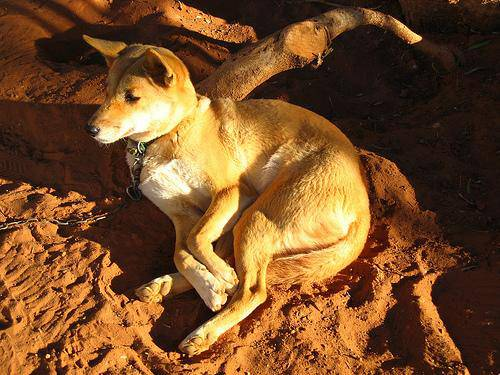

In [35]:
img = PIL.Image.open(fn); img

In [36]:
img.size # images are similar size to ImageNet model images

(500, 375)

In [37]:
size_d = {k: PIL.Image.open(DATA+k).size for k in data.trn_ds.fnames} #create dict of {filename: size of file(2-tuple)}

In [40]:
row_sz,col_sz = list(zip(*size_d.values())) #star unpacks collection into positional arguments

In [41]:
row_sz=np.array(row_sz); col_sz=np.array(col_sz)

In [42]:
row_sz[:5]

array([500, 500, 500, 500, 500])

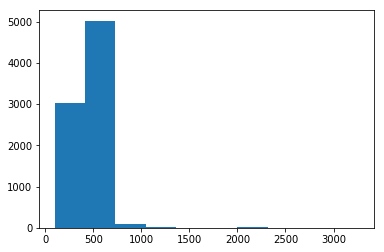

In [43]:
plt.hist(row_sz);

(array([  135.,   592.,  1347.,  1164.,  4599.,   128.,    76.,    62.,    14.,    11.]),
 array([  97. ,  185.5,  274. ,  362.5,  451. ,  539.5,  628. ,  716.5,  805. ,  893.5,  982. ]),
 <a list of 10 Patch objects>)

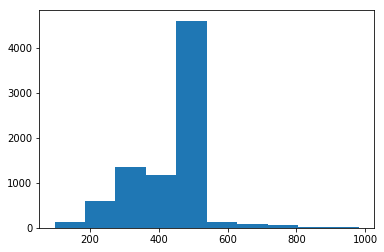

In [44]:
plt.hist(row_sz[row_sz<1000])

(array([ 2870.,  5121.,   128.,    25.,    10.,    15.,     5.,     2.,     0.,     2.]),
 array([  102.,   348.,   594.,   840.,  1086.,  1332.,  1578.,  1824.,  2070.,  2316.,  2562.]),
 <a list of 10 Patch objects>)

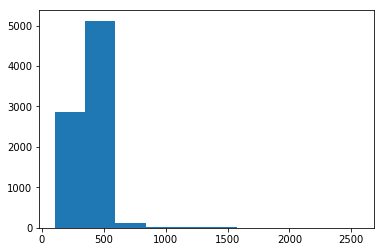

In [45]:
plt.hist(col_sz)

(array([  235.,   733.,  2205.,  2979.,  1807.,    98.,    27.,    33.,     7.,    10.]),
 array([ 102.,  190.,  278.,  366.,  454.,  542.,  630.,  718.,  806.,  894.,  982.]),
 <a list of 10 Patch objects>)

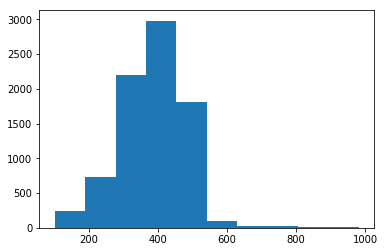

In [46]:
plt.hist(col_sz[col_sz<1000])

In [50]:
def get_data(sz,bs):
    """usually start with sz=64 and bs=64 and later sz=224"""
    tfms= tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(DATA, 'train', label_csv, test_name='test', num_workers=4, \
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

## Precompute

In [64]:
#arch=resnext101_64
arch=resnet34

In [65]:
get_data(224,64)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [66]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [00:24<00:00,  7.29it/s]


In [67]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 111/141 [00:01<00:00, 74.45it/s, loss=15.9]


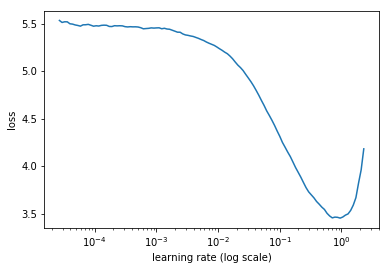

In [68]:
learn.sched.plot()

In [69]:
learn.fit((1e-1)/3, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.235889   0.708852   0.792419  
    1      0.785504   0.598672   0.816981                    
    2      0.579545   0.612238   0.820334                    
    3      0.493855   0.67575    0.81746                     
    4      0.435766   0.642045   0.814929                    



[0.64204478, 0.81492885119385194]

### Augment

In [70]:
from sklearn import metrics

In [71]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [72]:
learn.fit((1e-1)/3,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.523334   0.753484   0.784278  
    1      0.949145   0.594023   0.820197                    



[0.59402257, 0.82019705077012384]

In [73]:
learn.precompute=False

In [74]:
learn.fit((1e-1)/3,5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.833449   0.533545   0.825944  
    1      0.778511   0.510298   0.831212                    
    2      0.72488    0.501832   0.831212                    
    3      0.711492   0.498139   0.830733                    
    4      0.676709   0.503064   0.83217                     



[0.50306404, 0.83217022981908584]

In [77]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

In [76]:
bs = 64

In [78]:
learn.set_data(get_data(299,bs))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [79]:
learn.fit((1e-1)/3,3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.678139   0.431202   0.863639  
    1      0.65509    0.4259     0.861686                    
    2      0.621007   0.416883   0.863639                    



[0.41688266, 0.86363932304084301]

In [80]:
learn.fit((1e-1)/3,3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.581246   0.422268   0.859245  
    1      0.59872    0.435707   0.853841                    
    2      0.547309   0.418551   0.864583                    
    3      0.571452   0.439274   0.86071                     
    4      0.543387   0.424581   0.857747                    
    5      0.49389    0.414062   0.865104                    
    6      0.46755    0.411882   0.862174                    



[0.41188169, 0.86217447929084301]

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)